[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 500, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 500, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.6966 - loss: 0.5657 - val_accuracy: 0.8682 - val_loss: 0.3131
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.9001 - loss: 0.2664 - val_accuracy: 0.8588 - val_loss: 0.3332
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.9242 - loss: 0.2133 - val_accuracy: 0.8428 - val_loss: 0.3551
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.9383 - loss: 0.1714 - val_accuracy: 0.8230 - val_loss: 0.4043
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9419 - loss: 0.1639 - val_accuracy: 0.8692 - val_loss: 0.3719


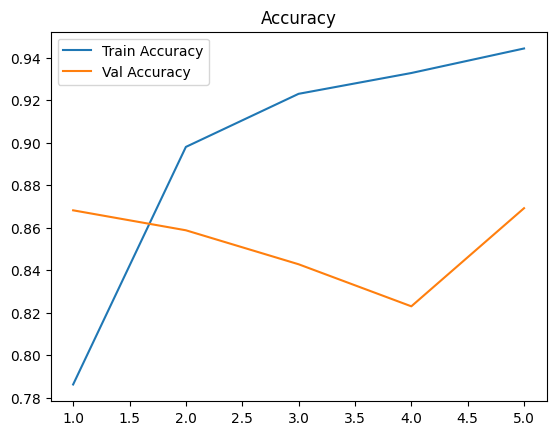

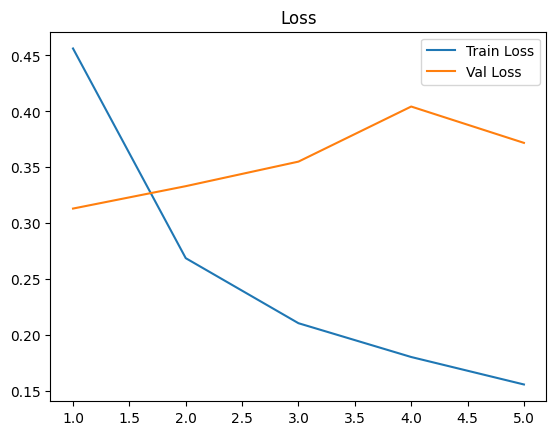

782/782 ━━━━━━━━━━━━━━━━━━━━ 87s 111ms/step

Accuracy: 0.85936

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86     12500
           1       0.86      0.86      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



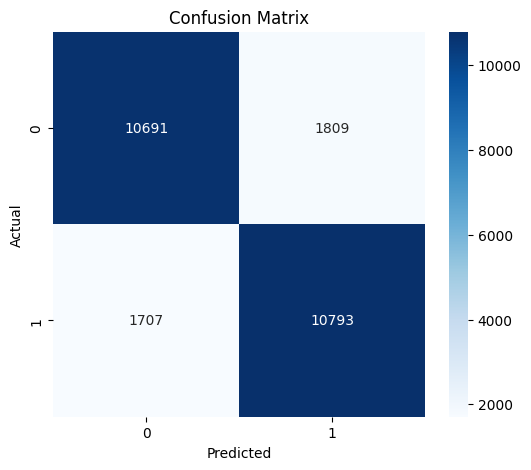

In [1]:
# ----------------------- IMPORTS -----------------------
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.datasets import imdb
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

# ----------------------- LOAD RAW IMDB DATA -----------------------
max_features = 10000
max_len = 500
EMBEDDING_DIM = 128
LSTM_DIM = 64

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=max_features)

word_index = imdb.get_word_index()
reverse_index = {v: k for k, v in word_index.items()}

def decode_review(encoded):
    return " ".join([reverse_index.get(i - 3, "?") for i in encoded])

train_text = [decode_review(x) for x in train_data]
test_text  = [decode_review(x) for x in test_data]

# ----------------------- STOP WORD REMOVAL -----------------------
def remove_stop(text):
    return " ".join([w for w in text.split() if w.lower() not in stop_words])

train_text = [remove_stop(t) for t in train_text]
test_text  = [remove_stop(t) for t in test_text]

# ----------------------- TOKENIZATION -----------------------
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_text)

X_train = tokenizer.texts_to_sequences(train_text)
X_test  = tokenizer.texts_to_sequences(test_text)

# ----------------------- PADDING -----------------------
X_train = pad_sequences(X_train, maxlen=max_len)
X_test  = pad_sequences(X_test, maxlen=max_len)

y_train = np.array(train_labels)
y_test  = np.array(test_labels)

# ----------------------- MODEL -----------------------
model = Sequential()
model.add(Embedding(max_features, EMBEDDING_DIM, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Build before summary
model.build(input_shape=(None, max_len))
model.summary()

# ----------------------- TRAINING -----------------------
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=128,
    validation_split=0.2
)

# ----------------------- GRAPHS -----------------------
def plot(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, label="Train Accuracy")
    plt.plot(epochs, val_acc, label="Val Accuracy")
    plt.title("Accuracy")
    plt.legend()
    plt.show()

    plt.plot(epochs, loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.title("Loss")
    plt.legend()
    plt.show()

plot(history)

# ----------------------- TEST METRICS -----------------------
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ----------------------- CONFUSION MATRIX -----------------------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [4]:
# ----------------------- SINGLE SENTENCE PREDICTION FUNCTION -----------------------
def predict_review(text):
    # 1) Stopword removal
    tokens = [w for w in text.lower().split() if w not in stop_words]
    cleaned = " ".join(tokens)

    # 2) Tokenize
    seq = tokenizer.texts_to_sequences([cleaned])

    # 3) Pad
    padded = pad_sequences(seq, maxlen=max_len)

    # 4) Predict
    pred = model.predict(padded)[0][0]

    # 5) Return class
    if pred > 0.5:
        return f"Prediction: POSITIVE ({pred:.2f})"
    else:
        return f"Prediction: NEGATIVE ({pred:.2f})"

print(predict_review("i really enjoyed last night"))
print(predict_review("I hate this film, it was the worst ever"))
print(predict_review("Very bad and horrible story"))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Prediction: POSITIVE (0.62)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Prediction: NEGATIVE (0.02)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Prediction: NEGATIVE (0.06)
